In [52]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from pycaret.regression import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

warnings.filterwarnings("ignore")

In [2]:
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [3]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'
# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This is how many features you want to keep in the final model
features_threshold = 10

In [4]:
# Set manually date if is necessary
model_run_date = datetime.today().strftime('%Y%m%d')
#model_run_date = '20220504'

In [32]:
# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
target_col = 'Payroll blended products'
has_drivers = True
#target_col = 'W-2 Revenue'
#has_drivers = False
#target_col = 'Delivery Revenue'
#has_drivers = False
#target_col = 'ASO Allocation'
#has_drivers = False
#target_col = 'Other Processing Revenue'
#has_drivers = False
#target_col = 'SurePayroll.'
#has_drivers = True
#target_col = 'Total international'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
#target_col = '401K Fee Revenue'
#has_drivers = True
#target_col = '401K Asset fee & BP Revenue'
#has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total ASO Revenue
# ------------------------------------------------------------------------------------- #
#target_col = 'HR Solutions (PEO)'
#has_drivers = False
#target_col = 'ASO Revenue - Oasis'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Online Services
# ------------------------------------------------------------------------------------- #
#target_col = 'HR Online'
#has_drivers = False
#target_col = 'Time & Attendance'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Other Management Solutions
# ------------------------------------------------------------------------------------- #
#target_col = 'Total Paychex Advance'
#has_drivers = True
#target_col = 'Full Service Unemployment Revenue'
#has_drivers = True
#target_col = 'ESR Revenue'
#has_drivers = True
#target_col = 'Cafeteria Plans Revenue'
#has_drivers = True
#target_col = 'Benetrac'
#has_drivers = True
#target_col = 'Emerging Products'
#has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total PEO
# ------------------------------------------------------------------------------------- #
#target_col = 'Total PEO'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Insurance Services
# ------------------------------------------------------------------------------------- #
# target_col = 'Workers Comp - Payment Services'
# has_drivers = True
#target_col = 'Health Benefits'
#has_drivers = True

#target_col = 'Interest on Funds Held for Clients'
#has_drivers = False

In [33]:
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [ml_col,uts_col,plan_col,fcst_col]
has_actuals = True
#has_drivers = False

In [34]:
# Get the full data frame and combine with drivers
#all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)

In [35]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path)

In [36]:
drive_path = proyect_path+"/data/clean/table_drivers.csv"
#driv_df_ = pd.read_csv(file_path, dtype={'Period':str, 'Calendar Date': str})
#driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, file_path)

In [37]:
all_df

Item,Calendar Date,401K Asset fee & BP Revenue,401K Fee Revenue,ASO Allocation,ASO Revenue - Oasis,Benetrac,Cafeteria Plans Revenue,Delivery Revenue,ESR Revenue,Emerging Products,...,Other Processing Revenue,Payroll blended products,SurePayroll.,Time & Attendance,Total PEO,Total Paychex Advance,Total international,W-2 Revenue,Workers Comp - Payment Services,Total Revenue
0,20140601,4261452.0,10621963.0,7255027.55,0.00,1922941.0,1714950.0,7393351.97,47602.0,796063.0,...,4765775.19,99633512.0,3246967.02,4651817.0,12948696.0,0.0,808003.64,7031234.09,4858397.0,2.074346e+08
1,20140701,4513388.0,10558382.0,9070820.80,0.00,1916579.0,1698495.0,13513741.18,67521.0,986955.0,...,6502729.54,121619696.0,3362473.02,5165885.0,14670286.0,0.0,855305.18,7325377.82,5244318.0,2.483619e+08
2,20140801,4486436.0,10297495.0,7489159.50,0.00,1944830.0,1829118.0,7286966.62,79771.0,924689.0,...,4215268.17,99472483.0,3286111.93,4856677.0,14606689.0,0.0,801651.38,7443620.46,5588578.0,2.110434e+08
3,20140901,4355891.0,12719409.0,7011292.24,0.00,1933042.0,1710602.0,7081861.96,105330.0,732444.0,...,4726806.24,94198230.0,3345328.53,5098280.0,14456325.0,0.0,834334.16,7414842.11,4968759.0,2.064182e+08
4,20141001,4455231.0,13797724.0,9372927.59,0.00,1956820.0,1702224.0,13741077.44,143956.0,1051920.0,...,6514037.07,124353873.0,3402641.78,5188982.0,14544813.0,0.0,869205.85,7818212.35,5752070.0,2.584593e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,20210901,9799382.0,17774640.0,17956420.34,240519.21,1387895.0,1602816.0,7779041.11,4262717.0,4935887.0,...,9225078.60,116406871.0,7427904.86,12506264.0,73460278.0,6112914.0,4699523.20,184562.25,6908722.0,3.709236e+08
88,20211001,9732791.0,14743885.0,16639812.59,260480.33,1487840.0,1630754.0,11268274.39,4033346.0,4965180.0,...,10636303.84,107455264.0,7524424.40,11891771.0,72816880.0,7191242.0,4509460.16,181163.07,6345526.0,3.574400e+08
89,20211101,10097325.0,15738895.0,18200667.03,235107.82,1563706.0,1621397.0,7617424.02,1612427.0,4695291.0,...,9402313.19,117503730.0,8070593.59,12248687.0,68898417.0,7614146.0,4468419.01,155279.24,6207581.0,3.646379e+08
90,20211201,9911484.0,16090695.0,19189993.34,305437.47,1500244.0,1647629.0,8212787.33,3983709.0,4913494.0,...,15988997.51,127800869.0,13553160.66,12098563.0,76848328.0,9863307.0,5355183.42,192584.15,8091726.0,4.078692e+08


In [38]:
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

In [39]:
external_path = proyect_path+"/data/external/external_data_fred.csv"
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})
#ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

In [40]:
# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

Shape of the training dataframe:
(72, 1363)
Shape of the testing dataframe:
(12, 1363)
Shape of the combination dataframe:
(84, 1363)


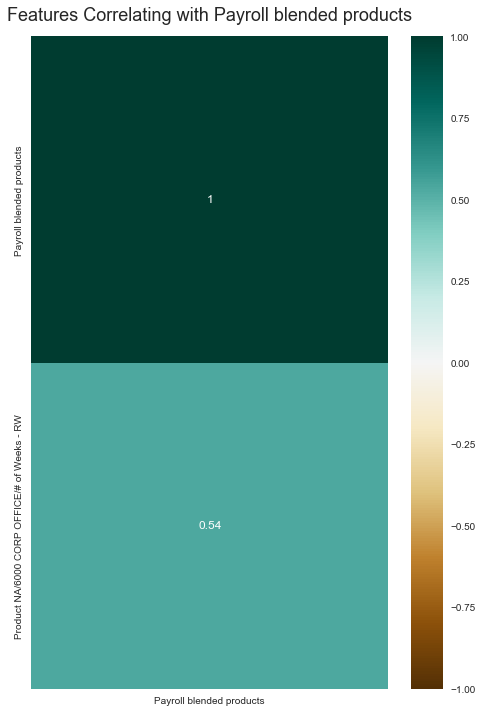

In [41]:
feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
corr_df = corr_df[corr_df[target_col].abs() >= correlation_threshold]

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

In [42]:
# run auto ml and get the most important features
best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5664788.8074,64219192075889.9688,7848126.0284,0.0200,0.0732,0.0524,0.0800
xgboost,Extreme Gradient Boosting,6063382.1667,62634500729514.6641,7800138.5000,0.0174,0.0715,0.0550,0.2133
lightgbm,Light Gradient Boosting Machine,6452555.9032,63340848032361.7891,7872521.8585,-0.0121,0.0714,0.0586,0.0300
rf,Random Forest Regressor,6475690.7452,66019255858966.1094,7972756.9237,-0.0330,0.0735,0.0599,0.0967
gbr,Gradient Boosting Regressor,6533440.2213,69555201177936.1641,8174033.8929,-0.0623,0.0759,0.0608,0.0967
knn,K Neighbors Regressor,6696725.0000,70100547796992.0000,8219107.5000,-0.0942,0.0762,0.0609,0.0167
dummy,Dummy Regressor,6761397.1667,68877178372096.0000,8176986.8333,-0.0736,0.0748,0.0618,0.0067
ada,AdaBoost Regressor,7829300.3980,96844474781280.8594,9681953.7430,-0.5511,0.0892,0.0715,0.0567
br,Bayesian Ridge,8099446.5260,136142890507324.7500,10130648.2360,-0.9883,0.1005,0.0736,0.8400
par,Passive Aggressive Regressor,8563869.0060,142897305130458.4375,11344289.1807,-1.1435,0.1042,0.0809,0.0133


<class 'sklearn.ensemble._forest.ExtraTreesRegressor'>


In [44]:
ml_features = models.get_important_features('xgboost', features_threshold)
ml_feature_cols = ml_features['Feature'].tolist()

if len(ml_features.index) != 0:
    # plot the most important features
    fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance',
                 y='Feature',
                 orientation='h',
                 title='Feature Importance Plot')
    fig.show()

In [45]:
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #
feature_cols = ml_feature_cols
keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5194547.3348,54026356948775.2422,7178749.4465,0.1811,0.0668,0.0479,0.1033
rf,Random Forest Regressor,5669058.8741,54879223817402.4609,7359689.2995,0.0947,0.0682,0.0519,0.0733
xgboost,Extreme Gradient Boosting,5728502.0000,60673360221525.3359,7691735.0000,-0.0026,0.0725,0.0526,0.1033
ada,AdaBoost Regressor,5845199.2208,58983811155976.6250,7542717.9595,0.0325,0.0702,0.0530,0.0300
gbr,Gradient Boosting Regressor,6101604.7295,64831346142322.6250,7924104.9018,-0.0474,0.0744,0.0558,0.0167
dummy,Dummy Regressor,6761397.1667,68877178372096.0000,8176986.8333,-0.0736,0.0748,0.0618,0.0067
lightgbm,Light Gradient Boosting Machine,6808708.0104,61672724599605.1562,7774255.9180,0.0064,0.0710,0.0620,0.0133
knn,K Neighbors Regressor,7598891.5000,93200424020650.6719,9644568.3333,-0.6814,0.0894,0.0680,0.0100
ridge,Ridge Regression,7668291.5000,117715034789205.3281,9999696.8333,-0.9130,0.0972,0.0697,0.0100
dt,Decision Tree Regressor,7838234.6667,98818907221549.0469,9870675.4903,-0.7013,0.0926,0.0722,0.0067


<class 'sklearn.ensemble._forest.ExtraTreesRegressor'>


In [46]:
# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

In [47]:
# create the future predictions dataframe
if has_actuals:
    act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
    act_df = act_df[['Calendar Date', target_col]]
    act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])
    pred_df = models.run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df = pred_df.rename(columns={'Label':ml_col})[['Calendar Date', ml_col]]
    concat_df = pd.merge(act_df, pred_df ,on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, type='plan')
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path,
                                type='forecast',
                                forecast_type=forecast_type)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1435.842, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1494.239, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1466.453, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1437.095, Time=0.24 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1436.992, Time=0.39 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1438.991, Time=0.68 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1464.711, Time=0.07 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1437.461, Time=0.16 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1437.098, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1507.718, Time=0.04 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(0,1,1)[12]             : 

In [48]:
# run UTS
uts_df = comb_df[['Calendar Date', target_col]]
uts_df = models.run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window)
uts_df.rename(columns={target_col:uts_col}, inplace=True)
concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2524.013, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2565.480, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2532.550, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2525.987, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2551.369, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2519.711, Time=0.48 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2521.286, Time=0.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2522.259, Time=0.27 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2521.163, Time=0.29 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=2523.375, Time=0.81 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=2521.703, Time=0.72 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2550.919, Time=0.18 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2519.808, Time=0.31 sec
 ARIMA(2,1,0)(0,1,2)[12]

In [49]:
# combine all data together
concat_df = pd.concat([comb_df[['Calendar Date', target_col]],concat_df], axis=0)

# show plot
fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
fig.show()

In [50]:
predictions_path = proyect_path+"/data/predictions/"+model_run_date
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)
    print("Directory created")

In [51]:
concat_df.to_parquet(predictions_path+"/"+target_col.replace(" ","")+".parquet")

In [54]:
# compute mape_df
mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
mape_df = models.compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
mape_df.rename(index={True:'MAPE'}, inplace=True)
#print(mape_df)

mapes_file = proyect_path + './mapes.xlsx'
#mape_df.to_excel(mapes_file, sheet_name=target_col[0:31])
book = load_workbook(mapes_file)
writer = pd.ExcelWriter(mapes_file, engine = 'openpyxl')
writer.book = book
mape_df.to_excel(writer, sheet_name = target_col[0:31], index=False)
book.save(mapes_file)
book.close()